In [1]:
import esp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from esp.lsst_utils import Sed, BandpassDict
%matplotlib inline

### Load templates and make uninterpolated training catalog

In [8]:
template_dir = '../data/templates/brown/'

In [9]:
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(template_dir)

for pca_sed in pca_obj.spec_list_orig:
    pca_sed.wavelen /= 10.
#pca_obj.PCA(comps=8, minWavelen=49., maxWavelen=1200.)

File On 100 out of 129
Done loading spectra from file


In [10]:
bandpass_dir = '../../ESP/data/lsst_bandpasses/'
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

In [11]:
pca_obj.spec_list_orig = pca_obj.spec_list_orig[:-1]

In [14]:
print(len(pca_obj.spec_list_orig))

129


In [13]:
colors = []
mags = []
spec_val = []
redshift = []
for z_shift in np.arange(0., 3.51, 0.05):
    i = 0
    for sed_obj in pca_obj.spec_list_orig:
        test_sed = deepcopy(sed_obj)
        test_sed.redshiftSED(z_shift)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags.append(sed_mags)
        colors.append(sed_mags[:-1] - sed_mags[1:])
        spec_val.append(i)
        redshift.append(z_shift)
        i+=1
colors = np.array(colors)
mags = np.array(mags)

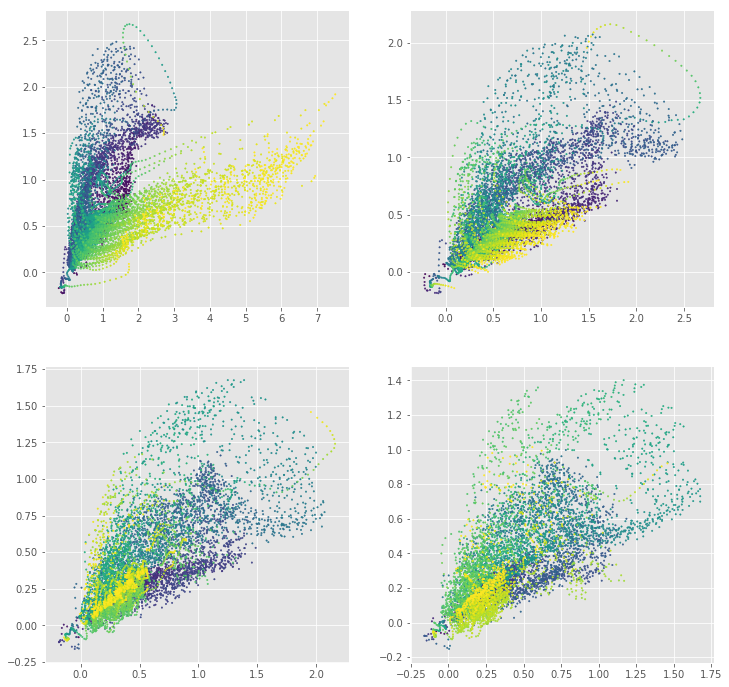

In [15]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:,i], colors[:,i+1], c=redshift, s=2)

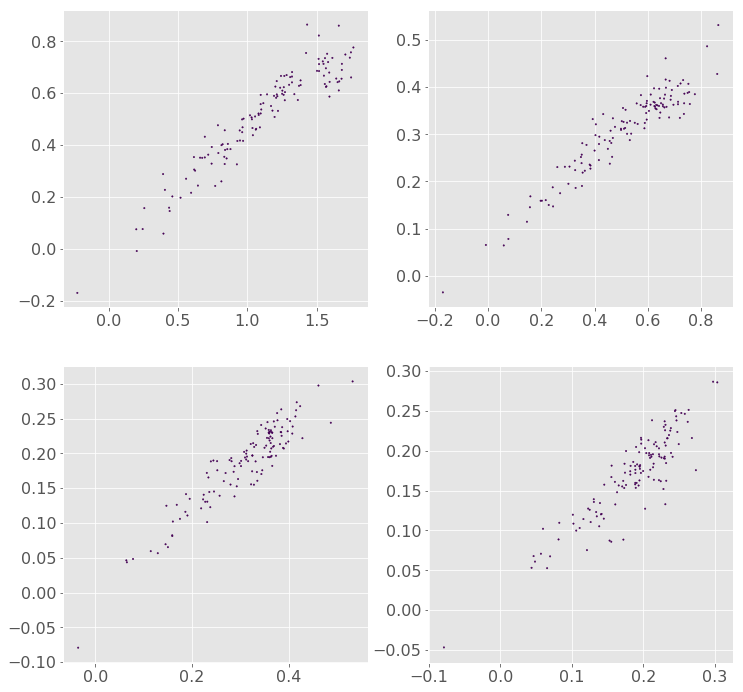

In [43]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:129,i], colors[:129,i+1], c=redshift[:129], s=2)

In [19]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift
for i, band in list(enumerate(filters)):
    sim_cat_df['%s_mag' % band] = mags[:, i]

In [20]:
np.savetxt('../../Data_Augment/brown_template_train.csv', sim_cat_df.values)

In [42]:
sim_cat_df.to_csv('../data/brown_template_train.csv')

In [44]:
rest_frame_colors = colors[:129]

### Fit Gaussian Mixture Model to draw locations for ESP estimation

In [45]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [62]:
x_train, x_test = train_test_split(rest_frame_colors, test_size = 0.3, random_state=1158)
for n_comp in range(1, 12):
    gmm = GaussianMixture(n_components=n_comp)
    gmm.fit(x_train)
    print(gmm.aic(x_test))

-525.4733324144077
-446.20358321811705
-417.0331423923758
-310.3767943219067
-63.764508293353686
237.41734681782808
542.5777029999239
123.9845373234192
243.91794889458154
1324.900713109249
2570.803295019407


In [73]:
gmm = GaussianMixture(n_components=1, random_state=8511).fit(rest_frame_colors)

In [74]:
x_predict = gmm.sample(n_samples=1000)

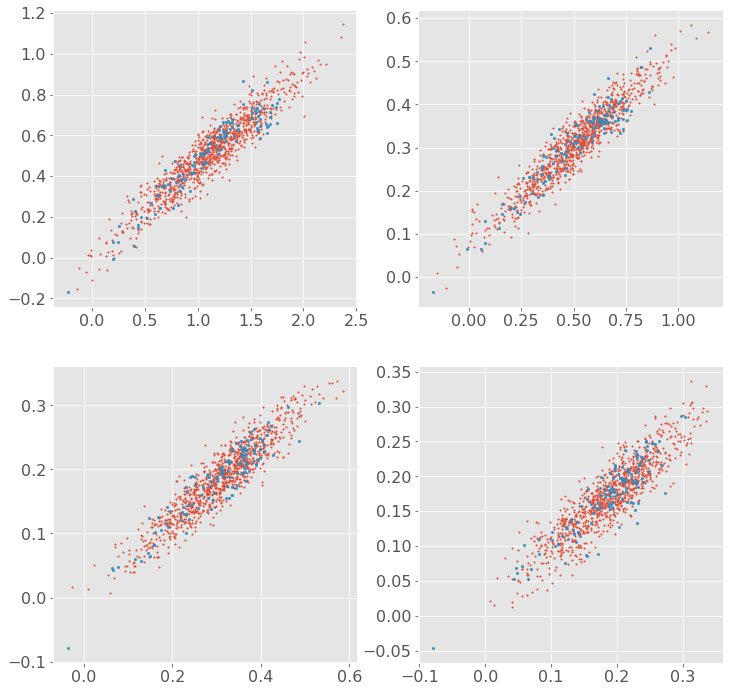

In [75]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(x_predict[0][:,i], x_predict[0][:,i+1], s=2)
    plt.scatter(rest_frame_colors[:,i], rest_frame_colors[:,i+1], s=6)

### Make denser training catalog

In [96]:
pca_obj.PCA(comps=10, minWavelen=49., maxWavelen=1200.)

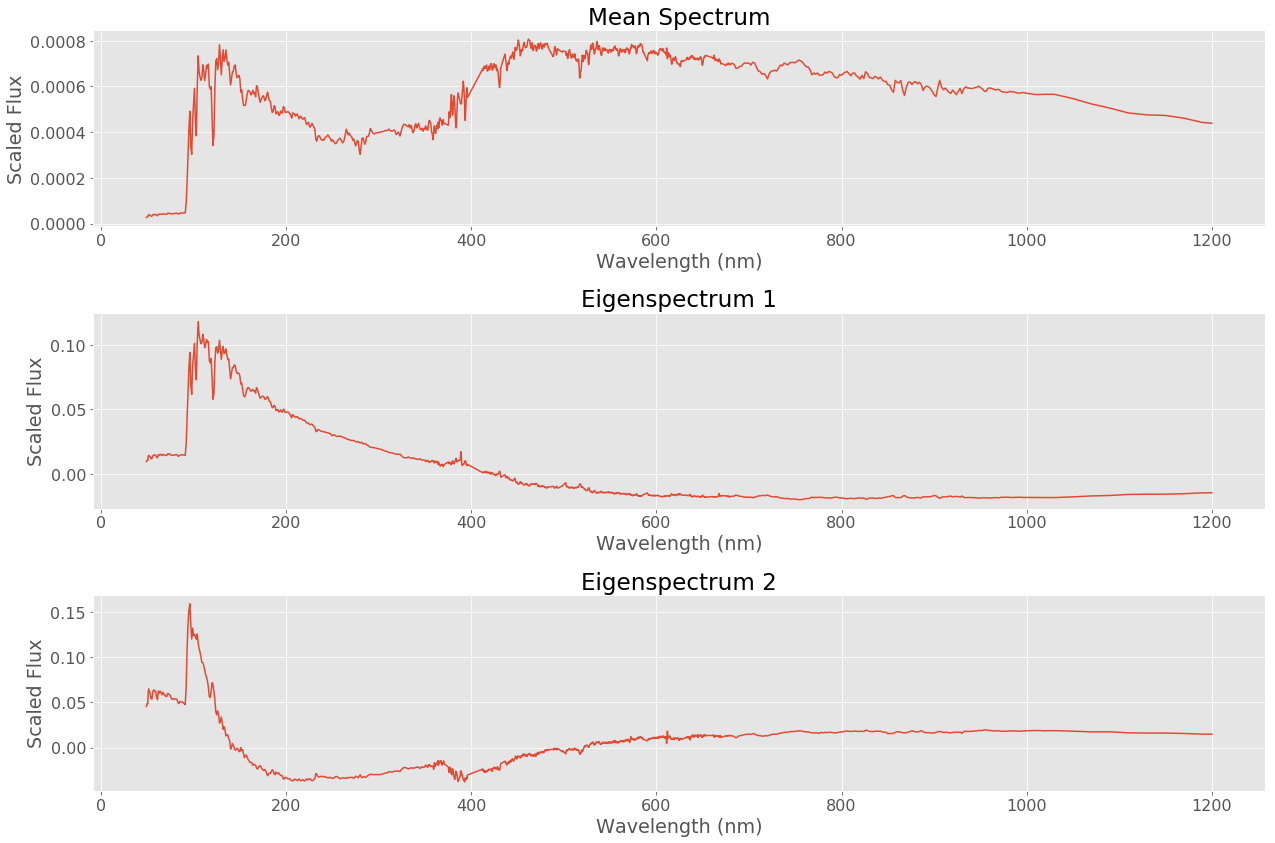

In [97]:
plotter = esp.plotUtils()
fig = plotter.plot_eigenspectra(pca_obj, 2)

In [98]:
np.sum(pca_obj.exp_var)

0.9919810148088698

In [81]:
import os
os.mkdir('brown_esp_results')
pca_obj.write_output('brown_esp_results')

In [101]:
gp_obj = esp.gaussianProcessEstimate(pca_obj, bandpass_dict, x_predict[0])

In [126]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=5)

In [127]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bandpass_dict)

In [128]:
gp_colors = gp_spec.calc_colors(bandpass_dict, 10)

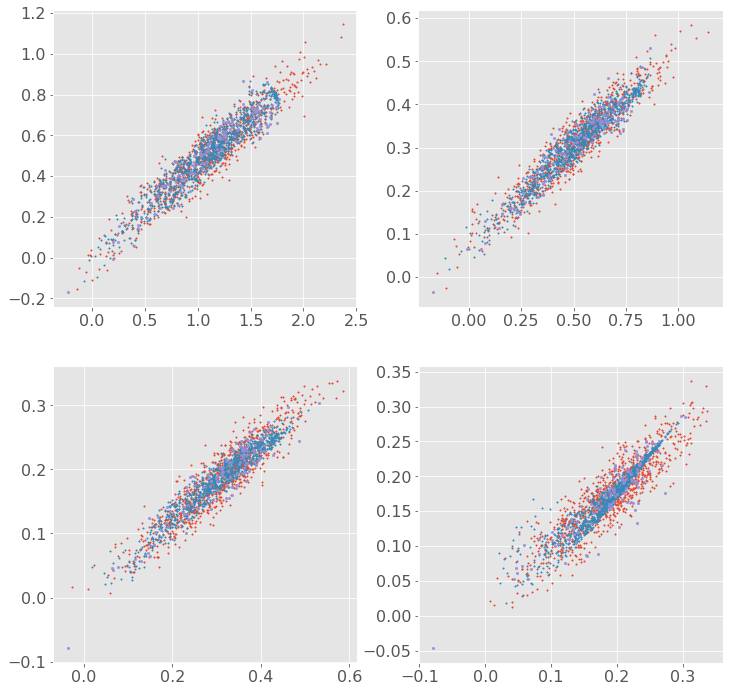

In [129]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(x_predict[0][:,i], x_predict[0][:,i+1], s=2)
    plt.scatter(gp_colors[:,i], gp_colors[:,i+1], s=2)
    plt.scatter(rest_frame_colors[:,i], rest_frame_colors[:,i+1], s=6)

In [125]:
#sq_exp_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#exp_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#m_52_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#m_32_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))

In [130]:
exp_err, sq_exp_err, m_32_err, m_52_err

(0.11338504810633099,
 0.18572091317839606,
 0.16826479765733976,
 0.18333227212094708)

In [221]:
best_fit = np.where(np.max((x_predict[0]**2. - gp_colors**2.), axis=1) < 0.005)[0]
print(len(best_fit))

206


In [222]:
new_spec = gp_spec.reconstruct_spectra(10)[best_fit]

In [223]:
np.exp(gp_spec.params)

array([[2.41297450e-04, 7.91725099e+02],
       [6.41732382e-05, 6.35994544e+02],
       [5.01309786e-06, 1.44006944e+01],
       [2.44414498e-06, 8.18558638e+01],
       [4.84978504e-08, 1.00298420e-03],
       [2.07975878e-07, 2.63856254e-01],
       [9.16778552e-07, 2.66825625e+01],
       [3.47939095e-08, 1.84267088e-02],
       [3.19666542e-08, 2.05197827e-02],
       [1.51709046e-08, 1.66206849e-03]])

In [224]:
colors = []
mags = []
spec_val = []
redshift = []
for z_shift in np.arange(0., 3.51, 0.05):
    i = 0
    for sed_obj in new_spec:
        test_sed = Sed()
        test_sed.setSED(wavelen=pca_obj.wavelengths, flambda=sed_obj)
        test_sed.redshiftSED(z_shift)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        if np.isinf(sed_mags).any():
            #print('drop')
            continue
        mags.append(sed_mags)
        colors.append(sed_mags[:-1] - sed_mags[1:])
        spec_val.append(i)
        redshift.append(z_shift)
        i+=1
colors = np.array(colors)
mags = np.array(mags)

/phys/users/brycek/.local/lib/python3.6/site-packages/esp/lsst_utils/Sed.py:1399: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*numpy.log10(fluxes) - self.zp


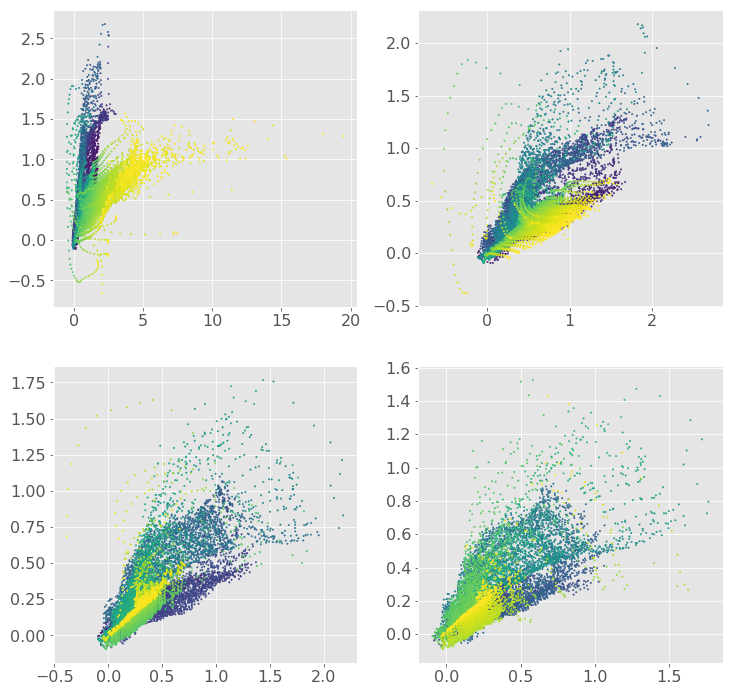

In [225]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:,i], colors[:,i+1], c=redshift, s=2)

In [226]:
len(redshift), len(mags)

(14599, 14599)

In [227]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift
for i, band in list(enumerate(filters)):
    sim_cat_df['%s_mag' % band] = mags[:, i]

In [228]:
np.savetxt('../../Data_Augment/brown_esp_template_only_train.csv', sim_cat_df.values)

#### Make combined catalog

In [229]:
sim_cat_brown = np.genfromtxt('../../Data_Augment/brown_template_train.csv')
sim_cat_esp = np.genfromtxt('../../Data_Augment/brown_esp_template_only_train.csv')

In [230]:
sim_cat = np.concatenate((sim_cat_brown, sim_cat_esp))

In [231]:
len(sim_cat), len(sim_cat_esp), len(sim_cat_brown)

(23758, 14599, 9159)

In [232]:
np.savetxt('../../Data_Augment/brown_esp_template_added_train.csv', sim_cat)

### Load in original training set and use missing color points as interpolation points

In [58]:
color_labels = np.genfromtxt('../data/train_labels_4_group_color_cut_0.dat')
full_train_set = pd.read_csv('../data/train_cat_full.dat')

In [69]:
missing_training = full_train_set.iloc[np.where(color_labels == 0.)].reset_index(drop=True)
for i in range(5):
    missing_training['%s-%s' % (filters[i], filters[i+1])] = \
        missing_training[filters[i]]-missing_training[filters[i+1]]

In [70]:
missing_training.head()

,redshift,u,g,r,i,z,y,u-g,g-r,r-i,i-z,z-y
0,0.753505,28.9604,27.8700,26.6609,25.6738,25.2948,25.1656,1.0904,1.2091,0.9871,0.3790,0.1292
1,1.735797,31.0933,29.0400,27.9654,27.2138,26.3419,26.0204,2.0533,1.0746,0.7516,0.8719,0.3215
2,1.023108,29.4540,27.5576,25.8060,24.8384,23.9023,23.5993,1.8964,1.7516,0.9676,0.9361,0.3030
3,1.890241,30.1426,27.3413,25.8079,25.1913,23.9993,23.6507,2.8013,1.5334,0.6166,1.1920,0.3486
4,0.490516,25.5690,23.4793,21.9750,21.1693,20.7393,20.6091,2.0897,1.5043,0.8057,0.4300,0.1302


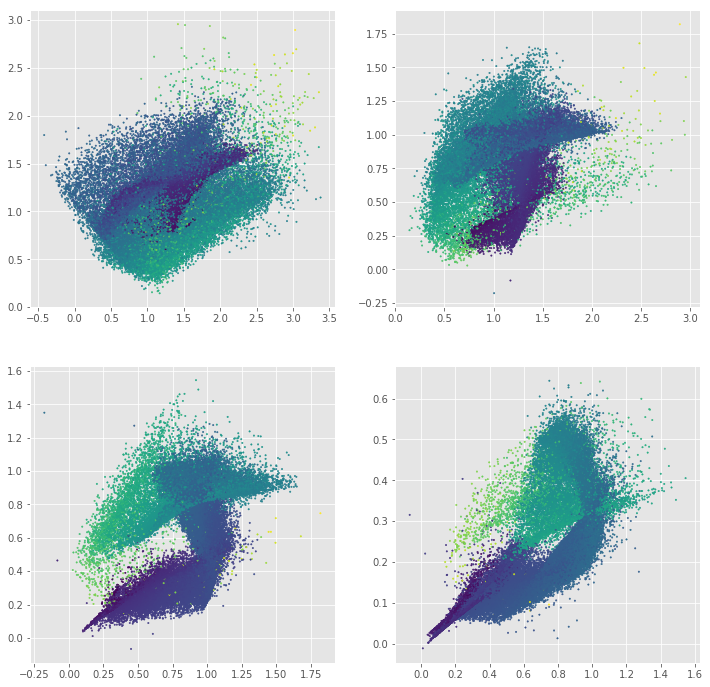

In [71]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(missing_training['%s-%s' % (filters[i], filters[i+1])],
                missing_training['%s-%s' % (filters[i+1], filters[i+2])],
                c=missing_training['redshift'], s=2)

0.9985451743326447